# Initialization

In [160]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import scipy.optimize
import glob
import os
from astropy.constants import G, M_sun, au

In [161]:
def cart_2_kep(x, y, z, vx, vy, vz):
    """
    Converts cartesian coordinates to Keplerian coordinates

    Parameters
    ----------
    x : float
        position (x-axis)
    y : float
        position (y-axis)
    z : float
        position (z-axis)
    vx : float
        velocity (x-axis) in AU/day (has already been multiplied by 0.01720209895 to be converted in AU/day)
    vy : float
        velocity (y-axis) in AU/day (has already been multiplied by 0.01720209895 to be converted in AU/day)
    vz : float
        velocity (z-axis) in AU/day (has already been multiplied by 0.01720209895 to be converted in AU/day)

    Returns
    -------
    a, e, cosi: float
        Keplerian coordinates of the protoplanets / planetesimals 

    """
    
    # Compute the radius, r, and velocity v
    r = np.sqrt(x**2 + y**2 + z**2)
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # Compute vector r and vector v
    r_vector = np.array([x, y, z])
    v_vector = np.array([vx, vy, vz])
    
    # Compute the specific angular momentum
    h_vector = np.cross(r_vector, v_vector)
    h = np.sqrt(h_vector[0]**2 + h_vector[1]**2 + h_vector[2]**2)
    
    # Compute the Standard gravitational parameter in AU/day
    mu_ms = G.value * M_sun.value # Standard gravitational parameter = GM of the central body
                                  # with G the Newtonian constant of gravitation (in m^3s^-2) 
    mu = mu_ms * (86400**2) / ((au.value)**3)    # There are 86400 s in a Julian day 
    
    # Compute the specific energy E
    E = ((v**2) / 2) - (mu / r)
    
    # Compute semi-major axis a
    a = - mu / (2 * E)
    
    # Compute eccentricity e
    e = np.sqrt(1 - (h**2 / (a * mu)))
    
    # Compute cosi
    cosi = h_vector[2]/h
    
    return a, e, cosi

In [162]:
class body:
    time:np.ndarray
    a:np.ndarray
    e:np.ndarray
    cosi:np.ndarray
    inc:np.ndarray
    q:np.ndarray
    qq:np.ndarray
    x:np.ndarray
    y:np.ndarray
    z:np.ndarray
    vx:np.ndarray
    vy:np.ndarray
    vz:np.ndarray
    mass:np.ndarray
    radius:np.ndarray
    idx:np.ndarray
    
    def __init__(self, filename: str):
        # Load the data from the Out*.dat file
        data = np.loadtxt(filename)
        # If only one line in the Out*.dat, the data are not a 2-D list and the values
        # must be loaded differently
        if data.shape == (21,):
            self.time = np.asarray([data[0]])
            self.idx = np.asarray([data[1]])
            self.mass = np.asarray([data[2]])   # in solar masses
            self.radius = np.asarray([data[3]]) # in AU
            self.radius_m = np.asarray([data[3]*au.value]) # in meters (not km!!)
            self.x = np.asarray([data[4]])
            self.y = np.asarray([data[5]])
            self.z = np.asarray([data[6]])
            self.vx = np.asarray([data[7]*0.01720209895]) # Convert the units of the velocity from AU/day' to AU/day
            self.vy = np.asarray([data[8]*0.01720209895]) # Convert the units of the velocity from AU/day' to AU/day
            self.vz = np.asarray([data[9]*0.01720209895]) # Convert the units of the velocity from AU/day' to AU/day
            
        else:
            self.time = data[:,0]
            self.idx = data[1,1]
            self.mass = data[:,2]  # in solar masses
            self.radius = data[:,3] # in AU
            self.radius_m = data[:,3]*au.value # in meters (not km!!)
            self.x = data[:,4]
            self.y = data[:,5]
            self.z = data[:,6]
            self.vx = data[:,7]*0.01720209895  # Convert the units of the velocity from AU/day' to AU/day
            self.vy = data[:,8]*0.01720209895  # Convert the units of the velocity from AU/day' to AU/day
            self.vz = data[:,9]*0.01720209895  # Convert the units of the velocity from AU/day' to AU/day

        self.filename = os.path.splitext(os.path.basename(filename))[0]
        self.len_time = len(self.time)
        self.a = np.zeros(self.len_time)
        self.e = np.zeros(self.len_time)
        self.cosi = np.zeros(self.len_time)
        self.inc = np.zeros(self.len_time)
        self.q = np.zeros(self.len_time)
        self.qq = np.zeros(self.len_time)
        for i in range(self.len_time):
            self.a[i] = cart_2_kep(self.x[i], self.y[i], self.z[i], self.vx[i], self.vy[i], self.vz[i])[0]
            self.e[i] = cart_2_kep(self.x[i], self.y[i], self.z[i], self.vx[i], self.vy[i], self.vz[i])[1]
            self.cosi[i] = cart_2_kep(self.x[i], self.y[i], self.z[i], self.vx[i], self.vy[i], self.vz[i])[2]
            self.inc[i] = np.arccos(self.cosi[i])  # in radians
            self.q[i] = self.a[i] * (1 - self.e[i])
            self.qq[i] = self.a[i] * (1 + self.e[i])

In [163]:
# Initialize the body list
body_list = []
body_list2 = []

In [164]:
# Find the directory in which the data are stored and fetch all files from the directory
for filename in glob.glob('/Users/sarahjoiret/Desktop/sims/genga/case2_output/big/clement/10000comets/2*/Outclement_p000*.dat', recursive=True):
    body_list.append(body(filename))
for filename in glob.glob('/Users/sarahjoiret/Desktop/sims/genga/case2_output/small/nesvorny/10000comets/1*/Outnesvorny_p000*.dat', recursive=True):
    body_list2.append(body(filename))

In [147]:
print(len(body_list))

1000


In [148]:
# Create a list with the remaining rocky planets at t = 100 Myr 
rockyplanet_list = []
giant_list = np.array(['Outnesvorny_p000000', 'Outnesvorny_p000001', 'Outnesvorny_p000002', 'Outnesvorny_p000003', 'Outnesvorny_p000004'])
#giant_list = np.array(['Outclement_p000000', 'Outclement_p000001', 'Outclement_p000002', 'Outclement_p000003', 'Outclement_p000004'])
for body in body_list:
    if body.len_time >= 4566 and body.mass[-1] > 1.0e-07 and body.filename not in giant_list: 
        rockyplanet_list.append(body)
for body in rockyplanet_list:
    print('a = ' + str(body.a[-1]) + ' and m = ' + str(body.mass[-1]) + ' with index = ' + str(body.idx))

a = 0.9759224972434826 and m = 3.907539642854881e-06 with index = 12.0
a = 0.6061060098622572 and m = 2.189543735312222e-06 with index = 21.0


# Find the planetesimals that formed the terrestrial planets analogs

In [167]:
# Find all the planetesimals that formed the Earth analog:
# From the filename that saves all the collisions between i and j
#filename_collisions = '/Users/sarahjoiret/Desktop/sims/genga/case2_output/big/clement/10000comets/2*/Collisionsclement.dat'
filename_collisions = '/Users/sarahjoiret/Desktop/sims/genga/case2_output/big/clement/10000comets/2*/Collisionsclement.dat'
collisions = np.genfromtxt(filename_collisions, dtype='str')
# Index of body i
idx_i = collisions[:,1].astype(float)
# Index of body j
idx_j = collisions[:,13].astype(float)
Earth_planetesimals_idx = []
Earth_planetesimals_idx.append(19.0) 
for i in range(len(idx_i)):
    # if collisions with the Earth analog (30 is the index of Earth analog)
    if idx_i[i] == 19:  
        #print('Collision of Earth with planetesimal n°' + str(idx_j[i]))
        Earth_planetesimals_idx.append(idx_j[i])
print(Earth_planetesimals_idx)
print(len(Earth_planetesimals_idx))

[19.0, 210.0, 290.0, 136.0, 73.0, 344.0, 508.0, 361.0, 295.0, 220.0, 283.0, 470.0, 21.0, 417.0, 137.0, 97.0, 18.0, 5.0, 366.0, 432.0, 10.0, 389.0, 392.0, 494.0, 410.0, 286.0, 109.0, 386.0, 422.0, 209.0, 232.0, 51.0, 510.0, 395.0, 435.0, 330.0, 420.0, 60.0, 70.0, 359.0, 355.0, 445.0, 236.0, 399.0, 231.0, 478.0, 164.0, 296.0, 293.0, 413.0]
50


In [168]:
# Find all the planetesimals that formed the Earth analog:
# From the filename that saves all the collisions between i and j
#filename_collisions = '/Users/sarahjoiret/Desktop/sims/genga/case2_output/big/clement/10000comets/2*/Collisionsclement.dat'
filename_collisions2 = '/Users/sarahjoiret/Desktop/sims/genga/case2_output/small/nesvorny/10000comets/1*/Collisionsnesvorny.dat'
collisions2 = np.genfromtxt(filename_collisions2, dtype='str')
# Index of body i
idx_i2 = collisions2[:,1].astype(float)
# Index of body j
idx_j2 = collisions2[:,13].astype(float)
Earth_planetesimals_idx2 = []
Earth_planetesimals_idx2.append(12.0)  
for i in range(len(idx_i2)):
    # if collisions with the Earth analog (30 is the index of Earth analog)
    if idx_i2[i] == 12:  
        #print('Collision of Earth with planetesimal n°' + str(idx_j[i]))
        Earth_planetesimals_idx2.append(idx_j2[i])
print(Earth_planetesimals_idx2)
print(len(Earth_planetesimals_idx2))

[12.0, 351.0, 334.0, 338.0, 31.0, 16.0, 13.0, 15.0, 515.0, 329.0, 182.0, 43.0, 41.0, 375.0, 208.0, 101.0, 204.0, 384.0, 123.0, 44.0, 154.0, 42.0, 105.0, 408.0, 281.0, 298.0, 129.0, 103.0, 48.0, 470.0, 29.0, 436.0, 315.0, 74.0, 162.0, 27.0, 228.0, 158.0, 53.0, 462.0, 453.0, 98.0, 6.0, 509.0, 302.0, 242.0]
46


In [169]:
# Find all the planetesimals that formed the Venus analog:
Venus_planetesimals_idx = []
Venus_planetesimals_idx.append(20.0)  
for i in range(len(idx_i)):
    if idx_i[i] == 20:  
        Venus_planetesimals_idx.append(idx_j[i])
print(Venus_planetesimals_idx)

[20.0, 483.0, 300.0, 15.0, 55.0, 396.0, 126.0, 6.0, 93.0, 509.0, 323.0, 363.0, 49.0, 52.0, 12.0, 188.0, 43.0, 267.0, 83.0, 387.0, 521.0, 284.0, 327.0, 11.0, 459.0, 14.0, 219.0, 311.0, 178.0, 195.0, 289.0, 443.0, 472.0, 247.0, 116.0, 150.0, 152.0, 385.0, 77.0, 62.0, 159.0, 348.0, 9.0, 326.0, 235.0, 17.0, 352.0, 156.0, 328.0, 377.0, 149.0, 135.0, 285.0, 239.0, 237.0, 342.0, 486.0, 92.0, 418.0, 241.0, 320.0, 471.0, 379.0, 68.0, 336.0, 437.0, 484.0, 439.0, 426.0, 84.0, 127.0, 264.0, 67.0, 245.0, 271.0, 132.0, 310.0, 476.0, 240.0, 475.0, 358.0, 298.0, 208.0, 48.0, 86.0, 350.0, 496.0, 507.0, 71.0, 162.0, 372.0, 490.0, 258.0, 66.0, 489.0, 453.0, 322.0, 160.0, 249.0, 167.0, 499.0, 216.0, 144.0, 408.0, 270.0, 277.0, 487.0, 120.0, 64.0, 98.0, 140.0, 291.0, 76.0, 115.0, 405.0, 441.0, 331.0, 229.0, 174.0, 193.0, 502.0, 262.0, 27.0, 343.0, 488.0, 111.0, 325.0, 442.0, 401.0, 36.0, 228.0, 233.0, 308.0, 185.0, 433.0, 391.0, 455.0, 218.0, 301.0, 403.0, 192.0, 268.0, 207.0, 347.0, 212.0, 314.0, 165.0, 2

In [186]:
# Find all the planetesimals that formed the Venus analog:
Venus_planetesimals_idx2 = []
Venus_planetesimals_idx2.append(21.0)  
for i in range(len(idx_i2)):
    if idx_i2[i] == 21:  
        Venus_planetesimals_idx2.append(idx_j2[i])
print(Venus_planetesimals_idx2)

[21.0, 410.0, 369.0, 26.0, 37.0, 7.0, 368.0, 219.0, 181.0, 274.0, 309.0, 380.0, 30.0, 203.0, 64.0, 364.0, 94.0, 430.0, 532.0, 454.0, 137.0, 70.0, 38.0, 51.0, 77.0, 39.0, 367.0, 111.0, 500.0, 332.0, 533.0, 17.0, 429.0, 251.0, 347.0, 170.0, 471.0, 469.0, 55.0, 345.0, 379.0, 480.0, 87.0, 414.0, 512.0, 113.0, 534.0, 297.0, 371.0, 195.0, 434.0, 540.0, 90.0, 180.0, 519.0, 459.0, 130.0, 370.0, 311.0, 487.0, 483.0, 138.0, 357.0, 374.0, 132.0, 201.0, 110.0, 339.0, 458.0, 529.0, 321.0, 172.0, 249.0, 503.0, 387.0, 313.0, 520.0, 40.0, 72.0, 496.0, 124.0, 294.0, 223.0, 116.0, 419.0, 544.0, 79.0, 209.0, 59.0]


In [187]:
# Find all the planetesimals that formed the Mars analog:
Mars_planetesimals_idx = []
Mars_planetesimals_idx.append(24.0)
for i in range(len(idx_i)):
    if idx_i[i] == 24:
        Mars_planetesimals_idx.append(idx_j[i])
print(Mars_planetesimals_idx)

[24.0, 370.0, 173.0, 398.0, 200.0, 161.0, 59.0, 125.0]


In [188]:
Earth_planetesimals = []
Venus_planetesimals = []
Earth_planetesimals2 = []
Venus_planetesimals2 = []
Mars_planetesimals = []
for body in body_list:
    if body.idx in Earth_planetesimals_idx:
        Earth_planetesimals.append(body)
    if body.idx in Venus_planetesimals_idx:
        Venus_planetesimals.append(body)
    if body.idx in Mars_planetesimals_idx:
        Mars_planetesimals.append(body)
for body2 in body_list2:
    if body2.idx in Earth_planetesimals_idx2:
        Earth_planetesimals2.append(body2)
    if body2.idx in Venus_planetesimals_idx2:
        Venus_planetesimals2.append(body2)

# Calculate the cum mass

In [189]:
list_a = np.arange(0.6, 1.6, 0.01)
m_Earth = np.zeros(len(list_a))
m_Venus = np.zeros(len(list_a))
m_Earth2 = np.zeros(len(list_a))
m_Venus2 = np.zeros(len(list_a))
m_Mars = np.zeros(len(list_a))
mtot_Earth = 2.138484416381762e-06
mtot_Venus = 4.38058921529892e-06 
mtot_Mars = 3.4840476446669207e-07
mtot_Earth2 = 3.907539642854881e-06
mtot_Venus2 = 2.189543735312222e-06
for count, a in enumerate(list_a):
    for p in Earth_planetesimals:
        if np.round(p.a[0],2) == np.round(a,2):
            if p.mass[-1] == mtot_Earth:
                m_Earth[count] = p.mass[0]/mtot_Earth
            else:
                m_Earth[count] += p.mass[-1]/mtot_Earth
    for pv in Venus_planetesimals:
        if np.round(pv.a[0],2) == np.round(a,2):
            if pv.mass[-1] == mtot_Venus:
                m_Venus[count] = pv.mass[0]/mtot_Venus
            else:
                m_Venus[count] += pv.mass[-1]/mtot_Venus
    for p2 in Earth_planetesimals2:
        if np.round(p2.a[0],2) == np.round(a,2):
            if p2.mass[-1] == mtot_Earth2:
                m_Earth2[count] = p2.mass[0]/mtot_Earth2
            else:
                m_Earth2[count] += p2.mass[-1]/mtot_Earth2
    for pv2 in Venus_planetesimals2:
        if np.round(pv2.a[0],2) == np.round(a,2):
            if pv2.mass[-1] == mtot_Venus2:
                m_Venus2[count] = pv2.mass[0]/mtot_Venus2
            else:
                m_Venus2[count] += pv2.mass[-1]/mtot_Venus2
    for pm in Mars_planetesimals:
        if np.round(pm.a[0],2) == np.round(a,2):
            if pm.mass[-1] == mtot_Mars:
                m_Mars[count] = pm.mass[0]/mtot_Mars
            else:
                m_Mars[count] += pm.mass[-1]/mtot_Mars
cum_Earth = np.cumsum(m_Earth)
cum_Venus = np.cumsum(m_Venus)
cum_Earth2 = np.cumsum(m_Earth2)
cum_Venus2 = np.cumsum(m_Venus2)
cum_Mars = np.cumsum(m_Mars)

# Plot

<IPython.core.display.Javascript object>


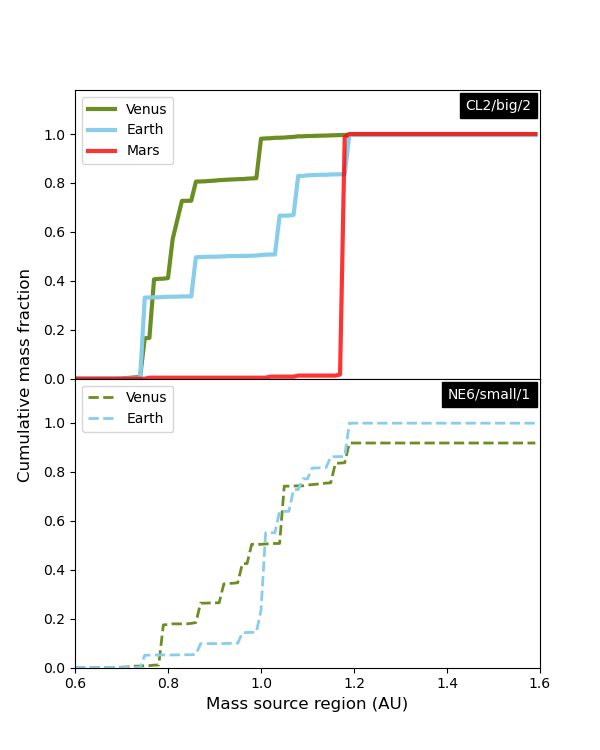

In [201]:
# Create the figure
#fig, ax = plt.subplots(figsize=(6.4, 4.5))
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(6,7.5))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
#scatter = ax.scatter([body.a[i] for body in body_list],[body.mass[i] for body in body_list], c= 'black', marker='.')
plt.xlabel('Mass source region (AU)', fontsize=12)
#plt.ylabel('Cumulative mass fraction', fontsize=12)
fig.supylabel('Cumulative mass fraction', x=0.03, y=0.5, fontsize=12)
plt.xlim(0.6, 1.6)
plt.ylim(0, 1.18)
ax[0].plot(list_a, cum_Venus, color = 'olivedrab', lw=3.0, label ='Venus')
ax[0].plot(list_a, cum_Earth, color = 'skyblue', lw=3.0, label ='Earth')
ax[0].text(1.44, 1.1, 'CL2/big/2', backgroundcolor = 'black', color='white')
ax[0].plot(list_a, cum_Mars, color = 'red', lw=3.0, alpha = 0.8, label ='Mars')
ax[1].plot(list_a, cum_Venus2, color = 'olivedrab', ls='--',lw=2.0, label ='Venus')
ax[1].plot(list_a, cum_Earth2, color = 'skyblue', ls ='--', lw=2.0, label ='Earth')
ax[1].text(1.402, 1.1, 'NE6/small/1', backgroundcolor = 'black', color='white')
ax[0].legend()
ax[1].legend()
plt.savefig('/Users/sarahjoiret/Desktop/sims/genga/case2_output/feeding_zone.pdf', dpi=300, bbox_inches='tight')